# MetaSUB Forensics Challenge

With over half of the world’s population living in urban areas, mass-transit systems like subways and buses represent some of the most shared environments in the world. While effectively transporting millions of people around urban areas, these transit systems also serve as a home to a rich community of microbes that share DNA and RNA with their human passengers. These unseen genetic interactions play important roles in public health and disease outbreak, yet little is known about mass-transit biomes. Fortunately, metagenomics, defined as the direct analysis of genetic material found in an environment, offers an opportunity to better understand the microbial communities present in our mass-transit systems.

To analyze the genetic interactions and community compositions of mass-transit biomes, The MetaSUB International Consortium (http://metasub.org/) has collected whole-genome sequencing (WGS) data from 16 cities across the world. Further, the Conference on Critical Assessment of Massive Data Analysis (CAMDA) has released their Metagenomics Forensics Challenge (http://www.camda.info/) -- predict the geographic origin of a metagenomic sample when no reference samples from that location are known. For this challenge, CAMDA has provided access to the 2019 MetaSUB WGS data.

In this study, we plan to build off the work of the MetaSUB global consortium and utilize the data provided by CAMDA to present a metagenomic analysis of mass-transit biomes from sixteen cities across the world (6 continents). The goal of our study is to effectively classify whole-genome sequencing (WGS) samples according to their city of origin and evenutally build a classification model to predict the origin of “unknown” metagenomic samples.

### Data processing and model setup

In [2]:
from __future__ import print_function
%matplotlib inline
import os, sys
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, log_loss

main_path = './data/camda.tsv'
mystery_path = './data/mystery.tsv'
mystery_labels_path = './data/MysterySamples_Labels.txt'
image_dir = './images'
df = pd.read_csv(main_path, '\t', index_col = 0)
mystery = pd.read_csv(mystery_path, '\t', index_col = 0)

# drop 'unclassified' columns
df = df.drop(['unclassified'], axis=1)
mystery = mystery.drop(['unclassified'], axis=1)

sampled_city_dict = {
    'AKL': {'loc': 'Auckland, New Zealand', 'continent': 'Australia'},
    'BER': {'loc': 'Berlin, Germany', 'continent': 'Europe'},
    'BOG': {'loc': 'Bogota, Columbia', 'continent': 'South America'},
    'HAM': {'loc': 'Hamilton, New Zealand', 'continent': 'Australia'},
    'HGK': {'loc': 'Hong Kong, China', 'continent': 'Asia'},
    'ILR': {'loc': 'Ilorin, Nigeria', 'continent': 'Africa'},
    'LON': {'loc': 'London, U.K.', 'continent': 'Europe'},
    'MAR': {'loc': 'Marsille, France', 'continent': 'Europe'},
    'NYC': {'loc': 'New York, U.S.A.', 'continent': 'North America'},
    'OFA': {'loc': 'Offa, Nigeria', 'continent': 'Africa'},
    'PXO': {'loc': 'Porto, Portugal', 'continent': 'Europe'},
    'SAC': {'loc': 'Sacramento, U.S.A.', 'continent': 'North America'},
    'SAO': {'loc': 'Sao Paulo, Brasil', 'continent': 'South America'},
    'SOF': {'loc': 'Sofia, Bulgaria', 'continent': 'Europe'},
    'STO': {'loc': 'Stockholm, Sweden', 'continent': 'Europe'},
    'TOK': {'loc': 'Tokyo, Japan', 'continent': 'Asia'}
}
    
df['continent'] = df['city'].map(lambda x: sampled_city_dict[x]['continent']) 

In [5]:
# city labels
y_city = df['city'] 
y_city_dummy = pd.get_dummies(y_city)

# continent labels
y_cont = df['continent']
y_cont_dummy = pd.get_dummies(y_cont)

# drop labels
X = df.drop(['city','continent'], axis=1)

# mystery sample processing
mystery_ids = mystery['label']
mystery = mystery.drop(['label'], axis=1)

#### Understanding the data

In this analysis, bacteria abundances are used as features for the classification of each metagenomic sample. Feature values were extracted from the output of a metagenomic phylogenetic analysis software called MetaPhlAn2. After running the software for all samples, I wrote a bash script to engineer this sparse dataframe object.

In [6]:
X 

,k__Archaea,k__Archaea|p__Crenarchaeota,k__Archaea|p__Crenarchaeota|c__Thermoprotei,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Desulfurococcales,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Desulfurococcales|f__Desulfurococcaceae,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Desulfurococcales|f__Desulfurococcaceae|g__Aeropyrum,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Desulfurococcales|f__Desulfurococcaceae|g__Aeropyrum|s__Aeropyrum_pernix,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Desulfurococcales|f__Desulfurococcaceae|g__Aeropyrum|s__Aeropyrum_pernix|t__GCF_000011125,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Thermoproteales,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Thermoproteales|f__Thermoproteaceae,...,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Cotton_leaf_curl_Multan_virus_satellite_U36_1,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Cotton_leaf_curl_Multan_virus_satellite_U36_1|t__PRJNA16312,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_PT1028,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_PT1028|t__PRJNA15262,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_ROSA,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_ROSA|t__PRJNA15274,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_phi2958PVL,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_phi2958PVL|t__PRJNA32173
csd16_AKL-001_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
csd16_AKL-001_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
csd16_AKL-002_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
csd16_AKL-002_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
csd16_AKL-003_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
csd16_AKL-003_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
csd16_AKL-004_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
csd16_AKL-004_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
csd16_AKL-005_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
csd16_AKL-005_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Let's first plot with TSNE and PCA to see if the data clusters with city and continent labels.

In [6]:
# dimensionality reduction functions
def find_dimension(X, cutoff):
    pca = PCA()
    pca.fit(X)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= cutoff)
    print('Using %d dimensions for tSNE reduction' % d)
    return d

def reduce_dim(X, cutoff):
    d = find_dimension(X, cutoff)
    pca = PCA(n_components=d)
    X_red = pca.fit_transform(X)
    return X_red

def tsner(X, labels, cutoff=0.95):
    X_reduced = reduce_dim(X, cutoff)
    tsne = TSNE(n_components=2, perplexity=40)
    tsne_results = tsne.fit_transform(X_reduced)
    X['tsne-2d-one'] = tsne_results[:,0]
    X['tsne-2d-two'] = tsne_results[:,1]
    X_viz = X[['tsne-2d-one','tsne-2d-two']]
    X_viz['Label'] = list(labels)
    return(X_viz)

Using 30 dimensions for tSNE reduction


/Users/keenanberry/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


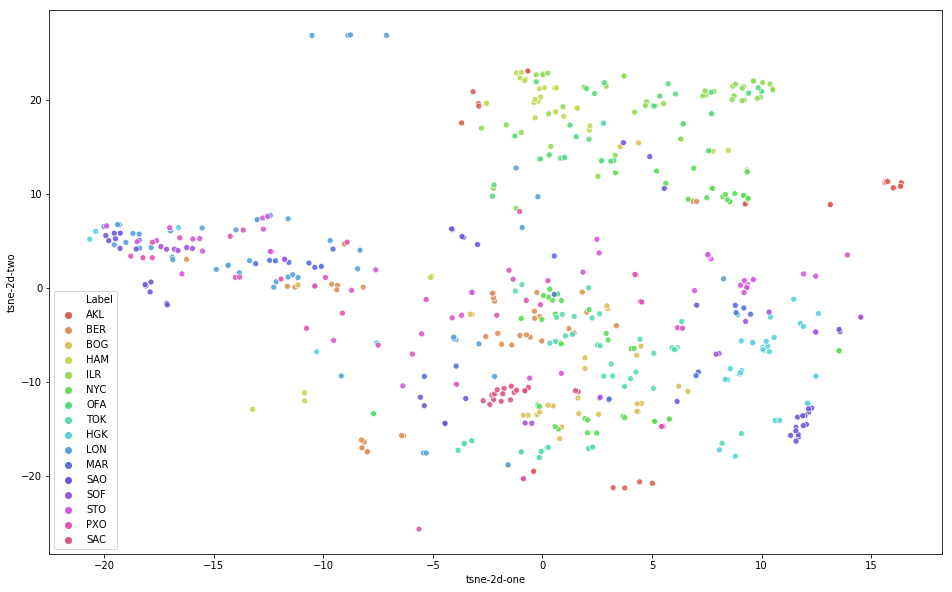

In [7]:
# visualize dimensionality reduction
viz_data = tsner(X, y_city)
# plot result
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Label",
    palette=sns.color_palette("hls", len(viz_data['Label'].value_counts())),
    data=viz_data,
    legend="full",
    alpha=0.9
)
plt.savefig(os.path.join(image_dir, 'city_tSNE.png'))

Using 31 dimensions for tSNE reduction


/Users/keenanberry/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


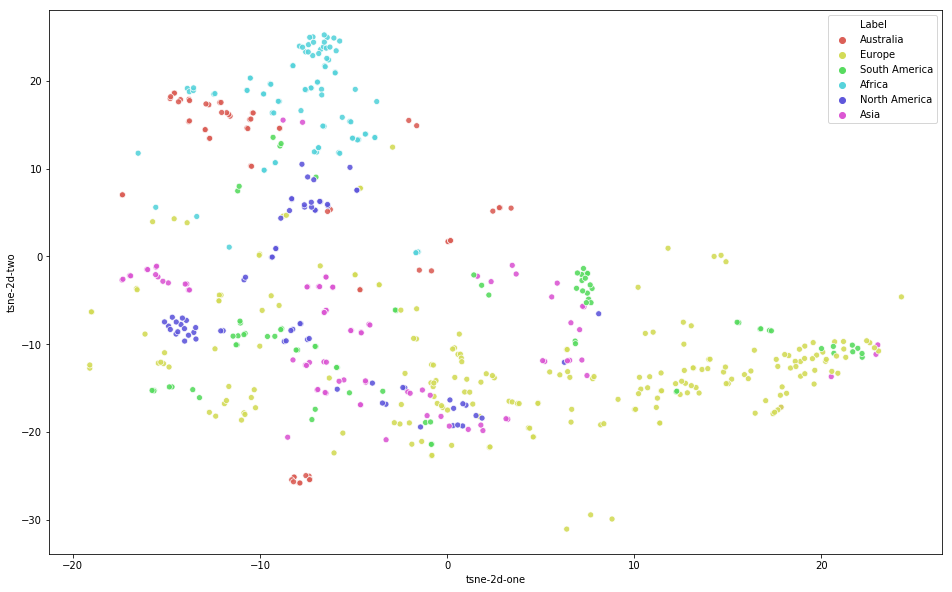

In [8]:
# visualize dimensionality reduction
viz_data = tsner(X, y_cont)
# plot result
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Label",
    palette=sns.color_palette("hls", len(viz_data['Label'].value_counts())),
    data=viz_data,
    legend="full",
    alpha=0.9
)
plt.savefig(os.path.join(image_dir, 'cont_tSNE.png'))

#### We can split the data into training and testing components.

In [10]:
X = X.drop(['tsne-2d-one','tsne-2d-two'], axis=1)

# split train and test
X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(X, y_cont, test_size=0.3, random_state=42, stratify=y_cont)
X_train_city, X_test_city, y_train_city, y_test_city = train_test_split(X, y_city, test_size=0.3, random_state=2, stratify=y_city)

# encode labels
contEncoder = LabelEncoder()
y_train_cont = contEncoder.fit_transform(y_train_cont).tolist()
y_test_cont = contEncoder.transform(y_test_cont).tolist()
cityEncoder = LabelEncoder()
y_train_city = cityEncoder.fit_transform(y_train_city).tolist()
y_test_city = cityEncoder.transform(y_test_city).tolist()

### Now, it's time to get learning!

The following classification analysis will attempt to classify metagenomic samples based on taxonomy abundances with their continent and city of origin. The results will inform the possibility of predicting the location of an unknown metagenomic sequencing sample. This sort of knowledge could be very useful in tracking and understanding disease outbreak at a population level.

We will be using a random forest model to train and predict sample labels. The model's hyperparameters will be optimized by using random search and grid search in sklearn. We will also check for the most dominant features, so that we can do some feature selection and pruning.

#### First, let's try to classify based on the continent in which samples were taken.

In [7]:
# RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, searched across 100 different combinations 
rf_random_cont = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3)

# fit model on continent labels
rf_random_cont.fit(X_train_cont, y_train_cont)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [8]:
rf_random_cont.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [17]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [70, 80, 90, 100, 110],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100, 150, 200, 250, 300]
}

# Create a model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search_cont = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)

grid_search_cont.fit(X_train_cont, y_train_cont)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bootstrap': [False], 'max_depth': [70, 80, 90, 100, 110], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 3, 4, 5], 'min_samples_split': [3, 4, 5, 6, 7], 'n_estimators': [50, 100, 150, 200, 250, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [18]:
grid_search_cont.best_params_

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

In [19]:
# get best model and make predictions
best_grid_cont = grid_search_cont.best_estimator_
cont_predictions = best_grid_cont.predict(X_test_cont)

In [20]:
# get results for continent
cont_score = accuracy_score(y_test_cont, cont_predictions)
cont_cm = confusion_matrix(y_test_cont, cont_predictions)
print(classification_report(y_test_cont, cont_predictions, 
                            target_names=contEncoder.inverse_transform([0, 1, 2, 3, 4, 5])))

print('\nOverall accuracy score = %f' % (cont_score*100))

               precision    recall  f1-score   support

       Africa       0.96      1.00      0.98        27
         Asia       0.93      1.00      0.96        26
    Australia       1.00      1.00      1.00        18
       Europe       1.00      0.97      0.98        63
North America       1.00      0.95      0.98        21
South America       1.00      1.00      1.00        23

  avg / total       0.98      0.98      0.98       178


Overall accuracy score = 98.314607


#### Now, we'll try to classifiy the city in which the samples were derived.

In [107]:
# use same param_distribution as above
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_city = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3)

# fit model on continent labels
rf_random_city.fit(X_train_city, y_train_city)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [118]:
rf_random_city.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 400}

In [119]:
# Create the parameter grid based on the results of random search 
city_grid = {
    'bootstrap': [False],
    'max_depth': [15, 20, 25, 30, 50],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [3, 4, 5, 6, 7],
    'n_estimators': [300, 350, 400, 450, 500]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search_city = GridSearchCV(estimator = rf, param_grid = city_grid, 
                          cv = 3)

grid_search_city.fit(X_train_city, y_train_city)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bootstrap': [False], 'max_depth': [15, 20, 25, 30, 50], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 3, 4], 'min_samples_split': [3, 4, 5, 6, 7], 'n_estimators': [300, 350, 400, 450, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [120]:
grid_search_city.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 300}

In [121]:
# get best model and make predictions
best_grid_city = grid_search_city.best_estimator_
city_predictions = best_grid_city.predict(X_test_city)

In [124]:
# get results for continent
city_score = accuracy_score(y_test_city, city_predictions)
city_cm = confusion_matrix(y_test_city, city_predictions)
print(classification_report(y_test_city, city_predictions, 
                            target_names=cityEncoder.inverse_transform(list(range(0, 16)))))

print('\nOverall accuracy score = %f' % (city_score*100))

             precision    recall  f1-score   support

        AKL       0.82      0.82      0.82        11
        BER       0.92      1.00      0.96        12
        BOG       1.00      1.00      1.00         7
        HAM       1.00      0.73      0.84        11
        HGK       0.89      0.80      0.84        10
        ILR       1.00      1.00      1.00        20
        LON       0.75      1.00      0.86        12
        MAR       0.75      1.00      0.86         3
        NYC       1.00      1.00      1.00        20
        OFA       1.00      1.00      1.00         9
        PXO       1.00      0.75      0.86        12
        SAC       1.00      1.00      1.00         5
        SAO       1.00      0.93      0.97        15
        SOF       1.00      1.00      1.00         6
        STO       0.73      1.00      0.84         8
        TOK       1.00      0.94      0.97        17

avg / total       0.94      0.93      0.93       178


Overall accuracy score = 93.258427


### Let's visualize our accuracy results

In [77]:
# function to save plot of sklearn.metrics confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          filename='confusion_matrix.png'):
    """
    This function creates and saves the confusion matrix plot.
    Normalization can be applied by setting `normalize=True`.
    Output file name can be selected by defining `filename=...`.
    """
    print('plotting confusion matrix...')
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.plot()
    #plt.savefig(os.path.join(image_dir, filename))
    #print('plot saved!') 
    plt.close()  # clear plot

plotting confusion matrix...


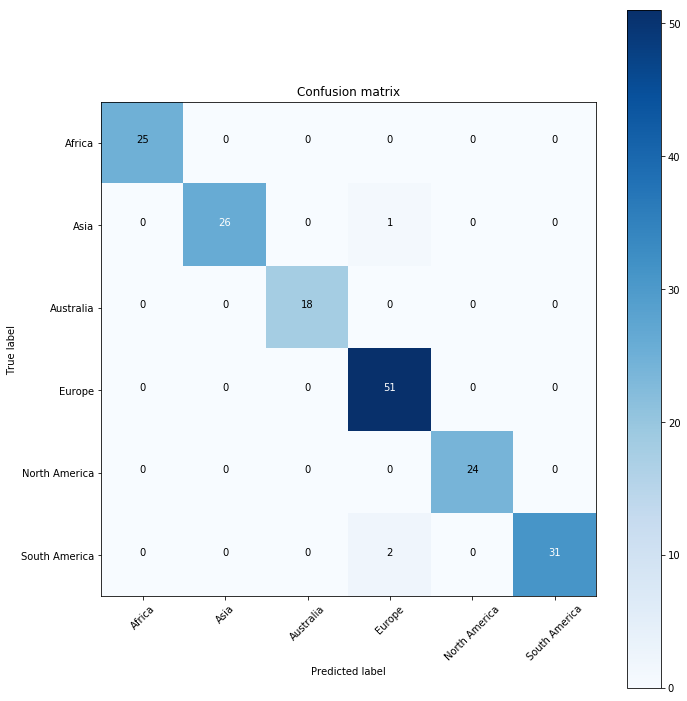

In [97]:
plot_confusion_matrix(
    cont_cm, 
    labelencoder.inverse_transform([0, 1, 2, 3, 4, 5]), 
    normalize=False, 
    filename='cont_confusion.png'
)

plotting confusion matrix...


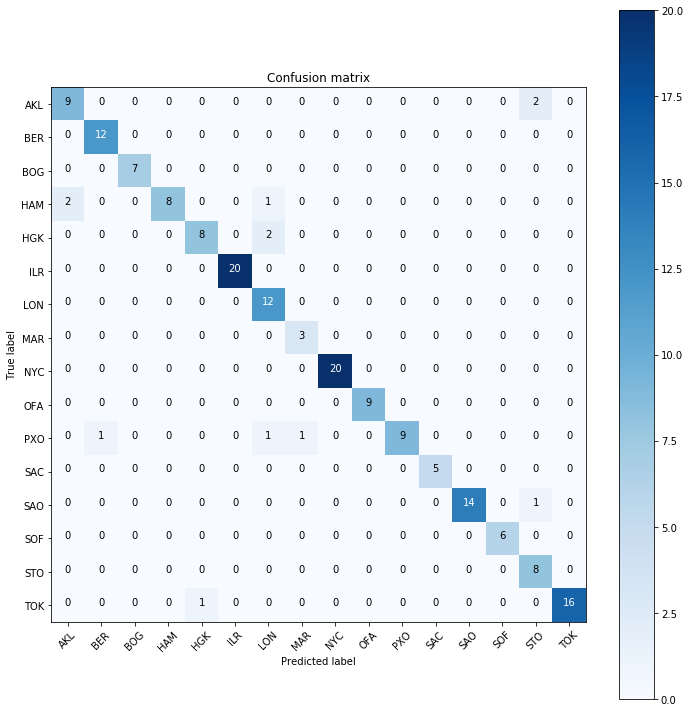

In [128]:
plot_confusion_matrix(
    city_cm, 
    cityEncoder.inverse_transform(list(range(0, 16))), 
    filename='city_confusion.png'
)

### Selecting the most important features

Although the most important features aren't used in this notebook to further refine the models above, it is good practice to understand how to select the most important features. Luckily, it's very easy with the random forest classifier from sklearn. Further analysis reveals that selection of the top 1000 taxa results in similar classification results for both the city and continent models.

#### Continent Classification

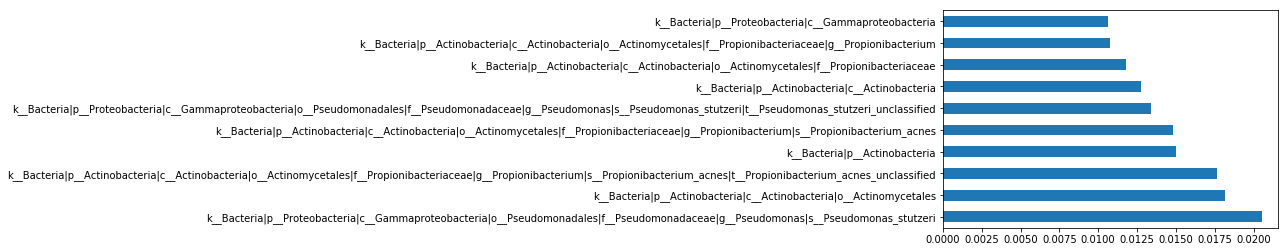

In [194]:
# graph of feature importances for better visualization
feat_importances_cont = pd.Series(best_grid_cont.feature_importances_, index=X_test.columns)
feat_importances_cont.nlargest(10).plot(kind='barh')
plt.show()

#### City classification

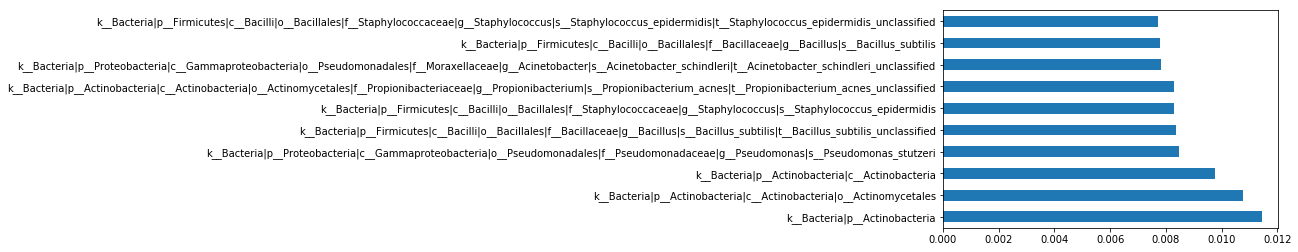

In [196]:
# graph of feature importances for better visualization
feat_importances_city = pd.Series(best_grid_city.feature_importances_, index=X_test_city.columns)
feat_importances_city.nlargest(10).plot(kind='barh')
plt.show()

### Mystery Sample Prediction

There are a total of 201 unmatched taxa in the mystery samples. These taxa cannot be found in the training set, and so are not included in our model. They are marked as "unclassified" and removed from the original dataframe upon loading.

In [7]:
mystery

,k__Archaea,k__Archaea|p__Crenarchaeota,k__Archaea|p__Crenarchaeota|c__Thermoprotei,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Desulfurococcales,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Desulfurococcales|f__Desulfurococcaceae,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Desulfurococcales|f__Desulfurococcaceae|g__Aeropyrum,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Desulfurococcales|f__Desulfurococcaceae|g__Aeropyrum|s__Aeropyrum_pernix,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Desulfurococcales|f__Desulfurococcaceae|g__Aeropyrum|s__Aeropyrum_pernix|t__GCF_000011125,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Thermoproteales,k__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Thermoproteales|f__Thermoproteaceae,...,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Cotton_leaf_curl_Multan_virus_satellite_U36_1,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Cotton_leaf_curl_Multan_virus_satellite_U36_1|t__PRJNA16312,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_PT1028,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_PT1028|t__PRJNA15262,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_ROSA,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_ROSA|t__PRJNA15274,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_phi2958PVL,k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname|f__Viruses_noname|g__Viruses_noname|s__Staphylococcus_phage_phi2958PVL|t__PRJNA32173
MspIkAOzT_2,0.00000,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0,0,0.0,0.0,0.00000,0.00000
YwEqI6j3T_1,0.00000,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0,0,0.0,0.0,0.00000,0.00000
rridyqqZl,0.00000,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0,0,0.0,0.0,0.00000,0.00000
zEyFbEnFu_2,0.00000,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0,0,0.0,0.0,0.00000,0.00000
S12fkE31f_1,0.00000,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0,0,0.0,0.0,0.00000,0.00000
LWrSv4rYd,0.00000,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0,0,0.0,0.0,0.00000,0.00000
qSkX1R2Gz_2,0.00000,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0,0,0.0,0.0,0.00000,0.00000
ya8Lwujnu_1,0.00000,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0,0,0.0,0.0,0.00000,0.00000
wJsZolv7O_1,0.00000,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0,0,0.0,0.0,0.00000,0.00000
Srryjh9fm,0.00000,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0,0,0.0,0.0,0.00000,0.00000


#### Now we can use our model above to predict the continental origins of these mystery samples.

In [21]:
# predict mystery continents
mystery_predictions = best_grid_cont.predict_proba(mystery)
mystery_classes = np.argmax(mystery_predictions, axis=1)
decoded_mystery_classes = list(contEncoder.inverse_transform(mystery_classes))

In [27]:
mystery_predictions_df = pd.DataFrame(
    list(zip(list(mystery.index), decoded_mystery_classes)), 
    columns =['mystery_sample', 'continent_of_origin?']
)

In [28]:
mystery_predictions_df

,mystery_sample,continent_of_origin?
0,MspIkAOzT_2,Europe
1,YwEqI6j3T_1,Australia
2,rridyqqZl,North America
3,zEyFbEnFu_2,Europe
4,S12fkE31f_1,Australia
5,LWrSv4rYd,Europe
6,qSkX1R2Gz_2,Europe
7,ya8Lwujnu_1,Asia
8,wJsZolv7O_1,Europe
9,Srryjh9fm,Europe
